In [7]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer

# Load the dataset
df = pd.read_csv('IMDB Dataset.csv', encoding='ISO-8859-1')

# Text preprocessing
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize the text
    words = word_tokenize(text)
    # Remove stopwords and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

# Clean the reviews
df['review'] = df['review'].apply(clean_text)

# Data augmentation functions
def synonym_replacement(text, n=1):
    words = text.split()
    new_words = words.copy()
    for _ in range(n):
        word_to_replace = np.random.choice(words)
        synonyms = get_synonyms(word_to_replace)
        if synonyms:
            synonym = np.random.choice(synonyms)
            new_words = [synonym if word == word_to_replace else word for word in new_words]
    return ' '.join(new_words)

def get_synonyms(word):
    synonyms = []
    for syn in nltk.corpus.wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.append(lemma.name())
    return list(set(synonyms))

def random_insertion(text, n=1):
    words = text.split()
    new_words = words.copy()
    for _ in range(n):
        add_word = np.random.choice(words)
        synonyms = get_synonyms(add_word)
        if synonyms:
            synonym = np.random.choice(synonyms)
            insert_idx = np.random.randint(0, len(new_words))
            new_words.insert(insert_idx, synonym)
    return ' '.join(new_words)

def random_swap(text, n=1):
    sentences = sent_tokenize(text)
    if len(sentences) < 2:
        return text
    new_sentences = sentences.copy()
    for _ in range(n):
        idx1, idx2 = np.random.choice(len(sentences), 2, replace=False)
        new_sentences[idx1], new_sentences[idx2] = new_sentences[idx2], new_sentences[idx1]
    return ' '.join(new_sentences)

def random_deletion(text, p=0.1):
    sentences = sent_tokenize(text)
    if len(sentences) == 1:
        return text
    new_sentences = [sentence for sentence in sentences if np.random.rand() > p]
    if not new_sentences:
        return np.random.choice(sentences)
    return ' '.join(new_sentences)

# Apply data augmentation to a random subset of 5000 reviews
augmented_reviews = []
augmented_sentiments = []

random_indices = np.random.choice(df.index, 5000, replace=False)

for idx in random_indices:
    review = df.loc[idx, 'review']
    sentiment = df.loc[idx, 'sentiment']
    augmented_reviews.append(synonym_replacement(review))
    augmented_sentiments.append(sentiment)
    augmented_reviews.append(random_insertion(review))
    augmented_sentiments.append(sentiment)
    augmented_reviews.append(random_swap(review))
    augmented_sentiments.append(sentiment)
    augmented_reviews.append(random_deletion(review))
    augmented_sentiments.append(sentiment)

# Create a DataFrame for the augmented data
augmented_df = pd.DataFrame({
    'review': augmented_reviews,
    'sentiment': augmented_sentiments
})

# Concatenate the original DataFrame with the augmented DataFrame
df = pd.concat([df, augmented_df])

# Save the cleaned and augmented dataset
df.to_csv('cleaned_augmented_IMDB_Dataset.csv', index=False)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ZHAN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ZHAN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ZHAN\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [1]:
pip list | grep tensorflow

Note: you may need to restart the kernel to use updated packages.


'grep' is not recognized as an internal or external command,
operable program or batch file.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70008 entries, 0 to 70007
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     70008 non-null  object
 1   sentiment  70008 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB
None
                                                   review sentiment
count                                               70008     70008
unique                                              56103         2
top     holy cow what a piece of sht this movie is i d...  negative
freq                                                    9     35112


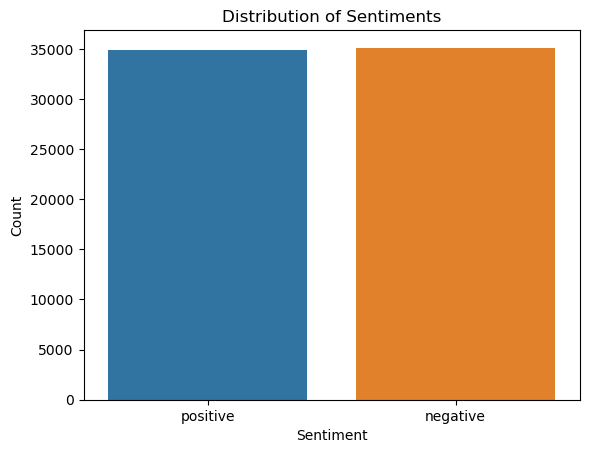

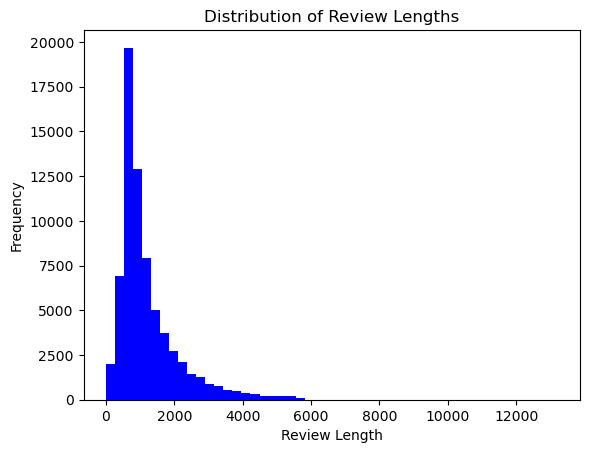

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('cleaned_augmented_IMDB_Dataset.csv', encoding='ISO-8859-1')

# Basic information about the dataset
print(df.info())
print(df.describe())

# Plot the distribution of the target variable
sns.countplot(x='sentiment', data=df)
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Visualize the length of reviews
df['review_length'] = df['review'].apply(len)
plt.hist(df['review_length'], bins=50, color='blue')
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
import datetime
# Load the dataset with specified encoding
df = pd.read_csv('cleaned_augmented_IMDB_Dataset.csv', encoding='ISO-8859-1')

# Text preprocessing
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

df['review'] = df['review'].apply(clean_text)

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X = tfidf.fit_transform(df['review']).toarray()

y = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the hypermodel
def build_model(hp):
    inputs = Input(shape=(X_train.shape[1],))
    x = Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu')(inputs)
    x = Dropout(rate=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1))(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model

# Define the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='hyperparameter_tuning',
    project_name='sentiment_analysis'
)

# Setup TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Perform hyperparameter tuning
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard_callback])

# Get the best hyperparameters and model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
loss, accuracy = best_model.evaluate(X_val, y_val)
print(f'Validation Accuracy: {accuracy:.2f}')

# Save the best model
best_model.save('best_sentiment_analysis_model.h5')

# Convert the best Keras model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('best_sentiment_analysis_model.tflite', 'wb') as f:
    f.write(tflite_model)

import pickle

# Assuming 'tokenizer' is already created and fitted
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

C:\Users\26083\AppData\Local\Temp\ipykernel_22488\21466543.py:18: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cleaned_augmented_IMDB_Dataset.csv', encoding='ISO-8859-1')
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\26083\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\26083\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Reloading Tuner from hyperparameter_tuning\sentiment_analysis\tuner0.json



C:\Users\26083\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9312 - loss: 0.1890
Validation Accuracy: 0.93


INFO:tensorflow:Assets written to: C:\Users\26083\AppData\Local\Temp\tmp2_wwh6_g\assets


INFO:tensorflow:Assets written to: C:\Users\26083\AppData\Local\Temp\tmp2_wwh6_g\assets


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\26083\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\26083\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\26083\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Reloading Tuner from hyperparameter_tuning\sentiment_analysis\tuner0.json


C:\Users\26083\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8227 - loss: 0.3998 - val_accuracy: 0.8944 - val_loss: 0.2550
Epoch 2/10
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9215 - loss: 0.2047 - val_accuracy: 0.9139 - val_loss: 0.2174
Epoch 3/10
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9478 - loss: 0.1468 - val_accuracy: 0.9217 - val_loss: 0.2078
Epoch 4/10
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9607 - loss: 0.1142 - val_accuracy: 0.9244 - val_loss: 0.2088
Epoch 5/10
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9715 - loss: 0.0905 - val_accuracy: 0.9264 - val_loss: 0.2178
Epoch 6/10
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9783 - loss: 0.0701 - val_accuracy: 0.9267 - val_loss: 0.2314
Epoch 7/10
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9856 - loss: 0.0540 - val_accuracy: 0.9263 - val_loss: 0.2438
Epoch 8/10
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9896 - loss: 0.0403 -

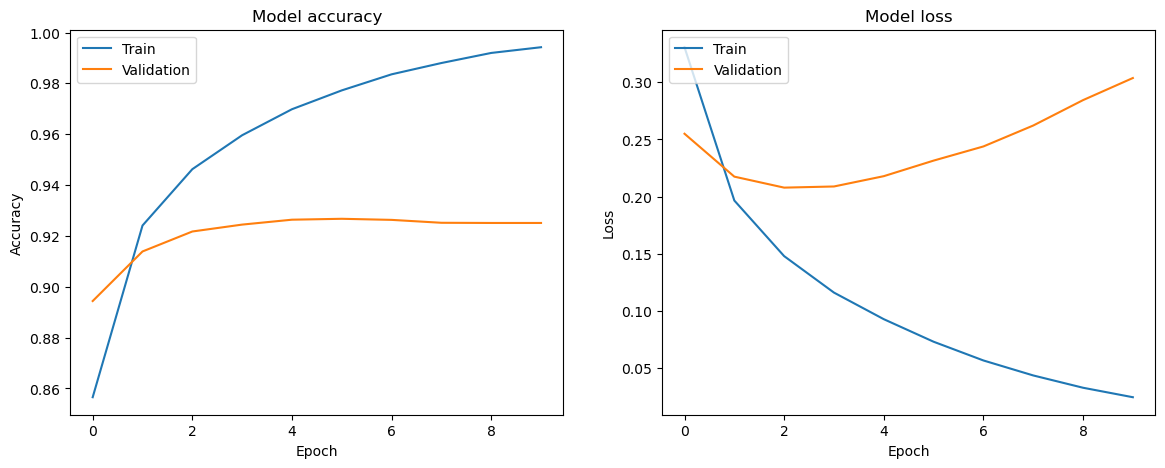

Results summary
Results in hyperparameter_tuning\sentiment_analysis
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 03 summary
Hyperparameters:
units: 160
dropout: 0.4
learning_rate: 0.0002860825237219976
Score: 0.9277603328227997

Trial 01 summary
Hyperparameters:
units: 32
dropout: 0.5
learning_rate: 0.0027547362874968547
Score: 0.9276888966560364

Trial 02 summary
Hyperparameters:
units: 96
dropout: 0.4
learning_rate: 0.0005102512655437227
Score: 0.9276888966560364

Trial 09 summary
Hyperparameters:
units: 32
dropout: 0.5
learning_rate: 0.002924269946621087
Score: 0.9275460839271545

Trial 06 summary
Hyperparameters:
units: 192
dropout: 0.5
learning_rate: 0.00028330421505152396
Score: 0.9274389445781708

Trial 04 summary
Hyperparameters:
units: 352
dropout: 0.5
learning_rate: 0.0003167431843224537
Score: 0.9274389445781708

Trial 00 summary
Hyperparameters:
units: 384
dropout: 0.30000000000000004
learning_rate: 0.0001350039327284823
Score: 0.92726039886

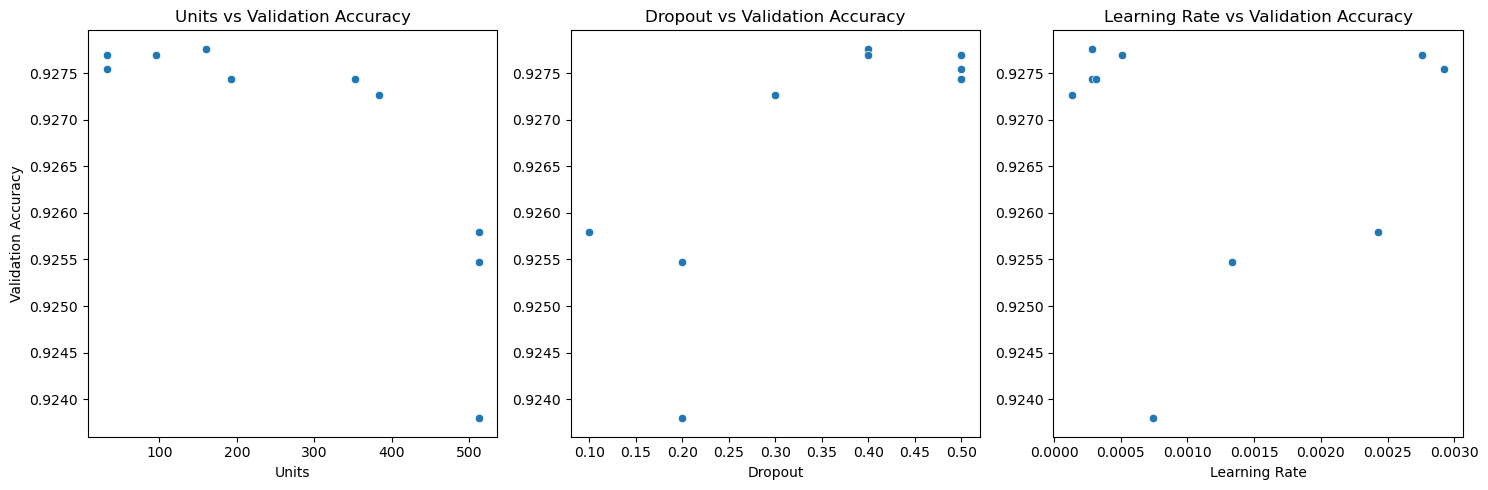

In [9]:
import pandas as pd
import numpy as np
import re
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
import datetime
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
# Load the dataset with specified encoding
df = pd.read_csv('cleaned_augmented_IMDB_Dataset.csv', encoding='ISO-8859-1')

# Text preprocessing
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

df['review'] = df['review'].apply(clean_text)

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X = tfidf.fit_transform(df['review']).toarray()

y = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the hypermodel
def build_model(hp):
    inputs = Input(shape=(X_train.shape[1],))
    x = Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu')(inputs)
    x = Dropout(rate=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1))(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model

# Define the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='hyperparameter_tuning',
    project_name='sentiment_analysis'
)

# Setup TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Perform hyperparameter tuning
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard_callback])

# Get the best hyperparameters and model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
history = best_model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard_callback])

loss, accuracy = best_model.evaluate(X_val, y_val)
print(f'Validation Accuracy: {accuracy:.2f}')

# # Save the best model
# best_model.save('best_sentiment_analysis_model.h5')

# # Convert the best Keras model to TensorFlow Lite format
# converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
# tflite_model = converter.convert()

# # Save the TensorFlow Lite model
# with open('best_sentiment_analysis_model.tflite', 'wb') as f:
#     f.write(tflite_model)

# # Save the TF-IDF vectorizer
# import pickle
# with open('tfidf_vectorizer.pickle', 'wb') as handle:
#     pickle.dump(tfidf, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Plotting the training history
def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.show()

plot_history(history)

# Visualization for hyperparameter tuning
def visualize_hyperparameter_tuning(tuner):
    # Get the summary of the search results
    tuner.results_summary()

    # Extract all trial results
    trials = tuner.oracle.get_best_trials(num_trials=10)
    units = [trial.hyperparameters.get('units') for trial in trials]
    dropout = [trial.hyperparameters.get('dropout') for trial in trials]
    learning_rate = [trial.hyperparameters.get('learning_rate') for trial in trials]
    val_accuracies = [trial.score for trial in trials]

    # Plot the hyperparameters
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    sns.scatterplot(x=units, y=val_accuracies, ax=axs[0])
    axs[0].set_title('Units vs Validation Accuracy')
    axs[0].set_xlabel('Units')
    axs[0].set_ylabel('Validation Accuracy')

    sns.scatterplot(x=dropout, y=val_accuracies, ax=axs[1])
    axs[1].set_title('Dropout vs Validation Accuracy')
    axs[1].set_xlabel('Dropout')

    sns.scatterplot(x=learning_rate, y=val_accuracies, ax=axs[2])
    axs[2].set_title('Learning Rate vs Validation Accuracy')
    axs[2].set_xlabel('Learning Rate')

    plt.tight_layout()
    plt.show()

visualize_hyperparameter_tuning(tuner)

In [13]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
import datetime
# Load the saved Keras model
model = tf.keras.models.load_model('best_sentiment_analysis_model.h5')
# Text preprocessing
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = nltk.WordNetLemmatizer()

# Assuming the same preprocessing steps as before
# Load and preprocess validation data
df = pd.read_csv('cleaned_augmented_IMDB_Dataset.csv', encoding='ISO-8859-1')

# Text preprocessing
def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

df['review'] = df['review'].apply(clean_text)
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X = tfidf.fit_transform(df['review']).toarray()
# TF-IDF Vectorization (if using TF-IDF)
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X = tfidf.fit_transform(df['review']).toarray()

y = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')

# Make predictions
y_pred = (model.predict(X_val) > 0.5).astype("int32")

# Print classification report
print(classification_report(y_val, y_pred))

# Print confusion matrix
print(confusion_matrix(y_val, y_pred))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\26083\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\26083\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\26083\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\26083\AppData\Local\Temp\ipykernel_67716\3667358236.py:40: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cleaned_augmented_IMDB_Dataset.csv', encoding='ISO-8859-1')


438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9312 - loss: 0.1890
Validation Loss: 0.1981
Validation Accuracy: 0.9279
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      6926
           1       0.93      0.93      0.93      7076

    accuracy                           0.93     14002
   macro avg       0.93      0.93      0.93     14002
weighted avg       0.93      0.93      0.93     14002

[[6428  498]
 [ 511 6565]]


In [1]:
import tensorflow as tf
print(tf.__version__)
# Save the best model in the SavedModel format
best_model.save('best_sentiment_analysis_model', save_format='tf')

# Save the tokenizer
import pickle

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

2.16.2


NameError: name 'best_model' is not defined